In [61]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw

In [83]:
translation_rates = np.array([[[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],            #Transition from V to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[ 2, 1.5, 1, 0.5,0.5,0.1],[-2,2, 1, 0.4, 0.1, 0]], #Transition from V to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 5, -1, -1, -1, -1]]],    #Transition from V to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[ -2, -1.5, -1, -0.5,-0.5,-0.1],[2,-2, -1, -0.4, -0.1, 0]],                   #Transition from R to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                      #Transition from R to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 5, -2, -2, -2, -2]]],   #Transition from R to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-5, 2, 2, 2, 2]],  #Transition from C to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-5, 2, 2, 2, 2]],  #Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]]]                    #Transition from C to C based on V,R,C neighbor
                            )

translation_rates_bkp = np.array([[[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],            #Transition from V to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[ 2, 1.5, 1, 0.5,0.5,0.1],[-2,2, 1, 0.4, 0.1, 0]], #Transition from V to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 25, -1, -1, -1, -1]]],    #Transition from V to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                   #Transition from R to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                      #Transition from R to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 25, -2, -2, -2, -2]]],   #Transition from R to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                     #Transition from C to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                      #Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]]]                    #Transition from C to C based on V,R,C neighbor
                            )
translation_rates_4params = np.array([[[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],            #Transition from V to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[ 2, 1.5, 1, 0.5,0.5,0.1],[-2,2, 1, 0.4, 0.1, 0],[0,0,0,0,0,0]], #Transition from V to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 5, -1, -1, -1, -1],[0,0,0,0,0,0]], #Transition from V to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]],    #Transition from V to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[ -2, -1.5, -1, -0.5,-0.5,-0.1],[2,-2, -1, -0.4, -0.1, 0],[0,0,0,0,0,0]],                   #Transition from R to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],                      #Transition from R to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3, 2, 1.5, 1, 1],[25, 5, -2, -2, -2, -2],[0,0,0,0,0,0]],                      #Transition from R to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]],   #Transition from R to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-5, 2, 2, 2, 2],[0,0,0,0,0,0]],  #Transition from C to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[-4, -3, -2, -1.5, -1, -1],[-25,-5, 2, 2, 2, 2],[0,0,0,0,0,0]],  #Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],  #Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]],   #Transition from R to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],  #Transition from C to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],  #Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],  #Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]]]                    #Transition from C to C based on V,R,C neighbor
                            )


amplify_c = 0.05
amplify_r = 1
amplify_v = 0.05
amplify_i = 0.05
translation_rates[0][1][:]=translation_rates[0][1][:] * amplify_r #Amplify occurance of R
#From Vacant
translation_rates[0][2][1]=translation_rates[0][2][1] * amplify_c #Amplify occurance of C from R 
translation_rates[0][2][2]=translation_rates[0][2][2] * amplify_c #Amplify occurance of C from C
#from residential
translation_rates[1][2][1]=translation_rates[1][2][1] * amplify_c #Amplify occurance of C from R
translation_rates[1][2][2]=translation_rates[1][2][2] * amplify_c #Amplify occurance of C from C
#from commercial
translation_rates[2][0][:]=translation_rates[2][0][:] * amplify_v #Amplify occurance of V from C
translation_rates[2][1][:]=translation_rates[2][1][:] * amplify_r #Amplify occurance of R from C

def mincelfun(inarr, params = 3,preservance = 300,perturbation=2.5,base = 1):
    """
    The function takes a timeslice of the array and calculates of proportions of each neighbour in Moore neighbourhood.
    """
    retprob = np.zeros(params) 
    totsum = 0
    map_center = int(math.floor(len(inarr)/2))
    center_param = int(inarr[map_center][map_center][0])
    retprob[center_param] = preservance
    for i, rowarr in enumerate(inarr):
        for j, val in enumerate(rowarr):
            mooredist = max([abs(i-map_center),abs(j-map_center)])-1
            if mooredist ==0:
                continue
            n_param = int(val[0])
            translations = [translation_rates[center_param][towards][n_param][mooredist]for towards in range(params)]
            retprob += translations # Uses value to index type of cell and increase value in prob array.
    totsum = sum(retprob)
    for g in range(params):
        if retprob[g]<0:
            retprob[g]=0
        else:
            stochastic_perturbation = 1 + (-1* np.log(np.random.rand()))**perturbation
            retprob[g] = stochastic_perturbation * retprob[g]
    
    totsum = sum(retprob)
    if (totsum <= 0): # Is this correct? totsum is only 0 if the function is passed an empty matrix. 
        retprob = np.zeros(params)
        retprob[center_param] = 1
        return retprob
    
    return retprob / float(totsum)



def CA_city(init_mat, moore_n = 6, params = 3, debug = False):
    """
    Loops through each cell and calculates its prob of changing state, then changes the state randomly.
    """
    # Assumes initmat is of shape N,N,2 
    init_dimx,init_dimy,init_pars = np.shape(init_mat)
    
    workgrid = np.zeros((init_dimx + 2 * moore_n, init_dimy + 2 * moore_n, init_pars)).astype(np.int8)
    retgrid = init_mat.astype(np.int8)
    workgrid[moore_n:-moore_n, moore_n:-moore_n] = init_mat.astype(np.int8)
    # Loops through the matrix dimensions, calls mincelfun() to find the values of neighbour cells. 
    for i,rowarr in enumerate(init_mat):
        for j,val in enumerate(rowarr):
            probs = mincelfun(workgrid[i:i+1 + 2*moore_n,j:j+1+2*moore_n], params = params)
            increase_param = np.random.choice(list(range(params)), 1, p = probs)
            # if/else checks which value was randomly selected in previous line and updates matrix accordingly.
            if increase_param == 0:
                continue
            elif increase_param == workgrid[i+moore_n, j+moore_n, 0]:
                retgrid[i,j,1] += 1
            else:
                retgrid[i,j] = [increase_param,1]
    return retgrid


def init_grid(N,params):
    """
    The function creates the initial state of the matrix and sets its values.
    Takes the dimensions of the grid and parameters as arguments and returns initial condition of matrix.
    """
    retgrid = np.zeros((N,N,2)).astype(np.int8)
    center = math.floor(N/2) # finds the center of the grid
    retgrid[:,:,1] = 1 # sets the center of the grid as a 1.
    retgrid[center,center,0] =1
    
    return retgrid

def simulate_CA_city(dimensions = 100,time = 30):
    ret_solution_dev = np.empty((time,dimensions,dimensions,2))
    init_city = init_grid(dimensions,3)
    ret_solution_dev[0] = init_city
    for step in range(1,time):
        ret_solution_dev[step] = CA_city(solution_dev[step-1],moore_n=6)
    return ret_solution_dev


def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        #print(cluster_ids)
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters






C:\Users\HP\AppData\Local\Temp\ipykernel_22492\542581724.py:140: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  retgrid[i,j] = [increase_param,1]


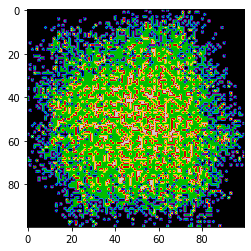

In [65]:
solution_dev = simulate_CA_city(100,30)
plt.imshow(solution_dev[29,:,:,0], cmap = 'nipy_spectral', vmin = 0, vmax = 2)

In [66]:
translation_rates[0][1][:]

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 2. ,  1.5,  1. ,  0.5,  0.5,  0.1],
       [-2. ,  2. ,  1. ,  0.4,  0.1,  0. ]])

In [67]:
solution_dev[8,20:60,20:60,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
state_occurrence = [np.unique(solution_dev[i,:,:,0], return_counts=True) for i in range(time)]
state_occurrence[4:]

[(array([0., 1., 2.]), array([9992,    7,    1], dtype=int64)),
 (array([0., 1., 2.]), array([9985,   14,    1], dtype=int64)),
 (array([0., 1., 2.]), array([9973,   25,    2], dtype=int64)),
 (array([0., 1., 2.]), array([9959,   39,    2], dtype=int64)),
 (array([0., 1., 2.]), array([9929,   65,    6], dtype=int64)),
 (array([0., 1., 2.]), array([9891,   99,   10], dtype=int64)),
 (array([0., 1., 2.]), array([9835,  146,   19], dtype=int64)),
 (array([0., 1., 2.]), array([9746,  215,   39], dtype=int64)),
 (array([0., 1., 2.]), array([9635,  307,   58], dtype=int64)),
 (array([0., 1., 2.]), array([9528,  390,   82], dtype=int64)),
 (array([0., 1., 2.]), array([9386,  507,  107], dtype=int64)),
 (array([0., 1., 2.]), array([9219,  641,  140], dtype=int64)),
 (array([0., 1., 2.]), array([9013,  796,  191], dtype=int64)),
 (array([0., 1., 2.]), array([8805,  958,  237], dtype=int64)),
 (array([0., 1., 2.]), array([8565, 1140,  295], dtype=int64)),
 (array([0., 1., 2.]), array([8308, 1319

In [75]:
total_cells = solution_dev[4,:,:,0].size
state_ratio = [state_occurrence[i][1] / total_cells for i in range(4,time)]


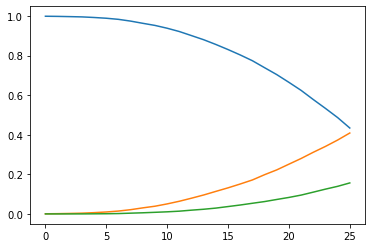

In [76]:
plt.plot(state_ratio)

In [77]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a*np.power(x, b)
x = run_clustering(solution_dev[29,:,:,0])
xx = x[x.cell_type == 1]
pars, cov = curve_fit(f=power_law, xdata=xx.Cluster_size, ydata=xx.Cluster_count, p0=[300, -1.8], bounds=(-np.inf, np.inf))

print(pars)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[341.6106458  -2.1529512]


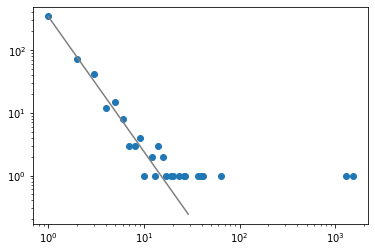

In [78]:
r = np.arange(1,30)
plt.scatter(xx.Cluster_size, xx.Cluster_count)
plt.plot(r, power_law(r, pars[0], pars[1]), c= 'grey')

plt.yscale('log'), plt.xscale('log')
plt.show()

In [149]:
test_repeats = 200
simulation_results = np.zeros((test_repeats,100,100)).astype(np.int8)
for i in range(test_repeats):
    solution_dev = simulate_CA_city(100,30)
    simulation_results[i] = solution_dev[29,:,:,0]
    
np.save("simulation_results.npy",simulation_results)
#loadtry = np.load("simulation_results.npy")


In [ ]:
x[i] = run_clustering(simulation_results[0])
xx[i] = x[i][x[i].cell_type == 1]
pars, cov = curve_fit(f=power_law, xdata=xx[i].Cluster_size, ydata=xx[i].Cluster_count, p0=[300, -1.8], bounds=(-np.inf, np.inf))




plt.scatter(xx.Cluster_size, xx.Cluster_count)

r = np.arange(1,30)
plt.plot(r, power_law(r, pars[0], pars[1]), c= 'grey')

plt.yscale('log'), plt.xscale('log')
plt.show()

In [ ]:

for i,size in range(xx.Cluster_size):
    for test_i in range(test_repeats):
        if 
    

In [157]:
x_clustersize

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14., 15.,
       16., 17., 19., 20., 27., 29., 39.])

In [159]:
x_clustersize = np.array(wrk.Cluster_size[wrk.cell_type==2])
x_clustercount = np.array(wrk.Cluster_count[wrk.cell_type==2])

In [160]:

for i, size in enumerate(wrk.Cluster_size[wrk.cell_type==2] -1):
    if size in x_clustersize:
        x_clustercount[x_clustersize==size] += wrk.Cluster_count[wrk.cell_type==2][i]
    else:
        x_clustercount = np.append(x_clustercount,wrk.Cluster_count[wrk.cell_type==2])
        x_clustersize = np.append(x_clustersize,size)
print(x_clustercount)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 21